# Circle Detection ML Challenge
> Rugved Chavan

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from typing import NamedTuple, Optional, Tuple, Generator
from matplotlib import pyplot as plt
from skimage.draw import circle_perimeter_aa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

## Given Code

In [5]:
class CircleParams(NamedTuple):
    row: int
    col: int
    radius: int


def draw_circle(img: np.ndarray, row: int, col: int, radius: int) -> np.ndarray:
    """
    Draw a circle in a numpy array, inplace.
    The center of the circle is at (row, col) and the radius is given by radius.
    The array is assumed to be square.
    Any pixels outside the array are ignored.
    Circle is white (1) on black (0) background, and is anti-aliased.
    """
    rr, cc, val = circle_perimeter_aa(row, col, radius)
    valid = (rr >= 0) & (rr < img.shape[0]) & (cc >= 0) & (cc < img.shape[1])
    img[rr[valid], cc[valid]] = val[valid]
    return img


def noisy_circle(img_size: int, min_radius: float, max_radius: float, noise_level: float) -> Tuple[np.ndarray, CircleParams]:
    """
    Draw a circle in a numpy array, with normal noise.
    """

    # Create an empty image
    img = np.zeros((img_size, img_size))

    radius = np.random.randint(min_radius, max_radius)

    # x,y coordinates of the center of the circle
    row, col = np.random.randint(img_size, size=2)

    # Draw the circle inplace
    draw_circle(img, row, col, radius)

    added_noise = np.random.normal(0.5, noise_level, img.shape)
    img += added_noise

    return img, CircleParams(row, col, radius)


def show_circle(img: np.ndarray):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_title('Circle')
    plt.show()


def generate_examples(noise_level: float = 0.5, img_size: int = 100, min_radius: Optional[int] = None, max_radius: Optional[int] = None, dataset_path: str = 'ds',) -> Generator[Tuple[np.ndarray, CircleParams], None, None]:
    if not min_radius:
        min_radius = img_size // 10
    if not max_radius:
        max_radius = img_size // 2
    assert max_radius > min_radius, "max_radius must be greater than min_radius"
    assert img_size > max_radius, "size should be greater than max_radius"
    assert noise_level >= 0, "noise should be non-negative"

    params = f"{noise_level=}, {img_size=}, {min_radius=}, {max_radius=}, {dataset_path=}"
    print(f"Using parameters: {params}")
    while True:
        img, params = noisy_circle(
            img_size=img_size, min_radius=min_radius, max_radius=max_radius, noise_level=noise_level
        )
        yield img, params


def iou(a: CircleParams, b: CircleParams) -> float:
    """Calculate the intersection over union of two circles"""
    r1, r2 = a.radius, b.radius
    d = np.linalg.norm(np.array([a.row, a.col]) - np.array([b.row, b.col]))
    if d > r1 + r2:
        # If the distance between the centers is greater than the sum of the radii, then the circles don't intersect
        return 0.0
    if d <= abs(r1 - r2):
        # If the distance between the centers is less than the absolute difference of the radii, then one circle is
        # inside the other
        larger_r, smaller_r = max(r1, r2), min(r1, r2)
        return smaller_r ** 2 / larger_r ** 2
    r1_sq, r2_sq = r1**2, r2**2
    d1 = (r1_sq - r2_sq + d**2) / (2 * d)
    d2 = d - d1
    sector_area1 = r1_sq * np.arccos(d1 / r1)
    triangle_area1 = d1 * np.sqrt(r1_sq - d1**2)
    sector_area2 = r2_sq * np.arccos(d2 / r2)
    triangle_area2 = d2 * np.sqrt(r2_sq - d2**2)
    intersection = sector_area1 + sector_area2 - (triangle_area1 + triangle_area2)
    union = np.pi * (r1_sq + r2_sq) - intersection
    return intersection / union

## Data Preprocessing

In [6]:
def create_dataset(num_samples, img_size=100, noise_level=0.5, min_radius=None, max_radius=None):
    """
    Generates a dataset of images and corresponding labels.

    Parameters:
    - num_samples (int): Number of samples to generate.
    - img_size (int, optional): Size of each image. Default is 100.
    - noise_level (float, optional): Level of noise to add to the images. Default is 0.5.
    - min_radius (int/float, optional): Minimum radius of objects in the generated images.
    - max_radius (int/float, optional): Maximum radius of objects in the generated images.

    Returns:
    tuple: A tuple containing two numpy arrays, one for images and one for labels.
    """
    # Initialize the data generator
    data_generator = generate_examples(noise_level, img_size, min_radius, max_radius)
    images = []
    labels = []

    # Generate images and labels
    for _ in range(num_samples):
        img, params = next(data_generator)
        images.append(img)
        labels.append([params.row, params.col, params.radius])

    # Convert lists to numpy arrays for further processing
    return np.array(images), np.array(labels)

def preprocess_images(images):
    """
    Preprocesses the images for model input.

    Parameters:
    - images (np.array): Array of images to preprocess.

    Returns:
    np.array: Preprocessed array of images.
    """
    # Ensure all pixel values are non-negative
    images = np.clip(images, 0, None)

    # Normalize pixel values to the range [0, 1]
    images = images / np.max(images)

    # Add a channel dimension to the images
    images = np.expand_dims(images, axis=-1)
    return images

# Create and preprocess the training and testing datasets
train_images, train_labels = create_dataset(8000)
test_images, test_labels = create_dataset(2000)

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

# Print the shape of the processed datasets
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")


Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Using parameters: noise_level=0.5, img_size=100, min_radius=10, max_radius=50, dataset_path='ds'
Train images shape: (8000, 100, 100, 1)
Test images shape: (2000, 100, 100, 1)


## Visualize the data with the annotation based on X,Y,Radius

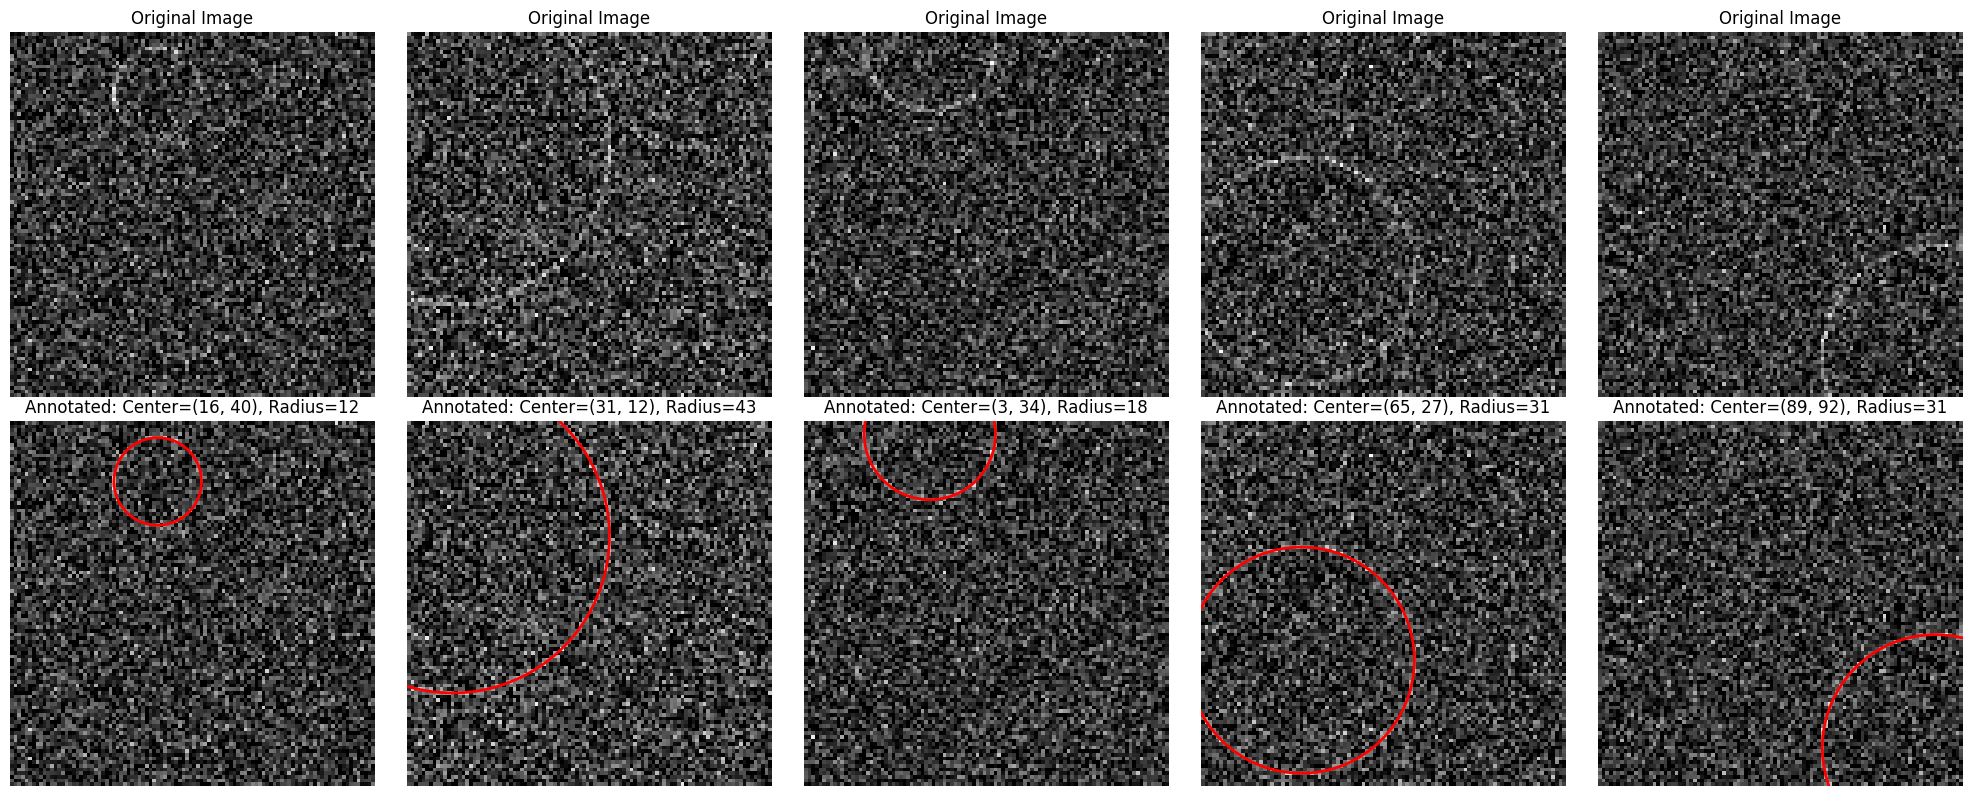

In [10]:
def visualize_data_with_annotations(images, labels, num_samples=5):
    """
    Visualizes a set of images with and without annotations.

    Parameters:
    - images (np.array): Array of images to be visualized.
    - labels (np.array): Corresponding labels containing annotation details.
    - num_samples (int, optional): Number of samples to visualize. Default is 5.

    Displays a grid of images, with the top row showing the original images, and 
    the bottom row showing the images with annotated circles.
    """
    # Create a subplot with 2 rows and num_samples columns
    fig, axs = plt.subplots(2, num_samples, figsize=(20, 8))

    for i in range(num_samples):
        img = images[i].squeeze()  # Remove channel dimension for visualization
        row, col, radius = labels[i]

        # Display original images in the first row
        axs[0, i].imshow(img, cmap='gray')
        axs[0, i].set_title("Original Image")
        axs[0, i].axis('off')

        # Display images with annotations in the second row
        axs[1, i].imshow(img, cmap='gray')
        circle = patches.Circle((col, row), radius, linewidth=2, edgecolor='r', facecolor='none')
        axs[1, i].add_patch(circle)
        axs[1, i].set_title(f"Annotated: Center=({row}, {col}), Radius={radius}")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()


# Visualize a subset of the dataset
visualize_data_with_annotations(train_images, train_labels, num_samples=5)


# Model Creation

## Create a IoU Merics

In [13]:
def tf_iou(y_true, y_pred):
    """
    Calculates the Intersection over Union (IoU) for circles.

    Parameters:
    - y_true (tf.Tensor): True values of the circle parameters [x_center, y_center, radius].
    - y_pred (tf.Tensor): Predicted values of the circle parameters.

    Returns:
    tf.Tensor: The mean IoU for the batch of predictions.
    """
    y_true = tf.cast(y_true, tf.float32)  # Convert to float32 for calculation
    y_pred = tf.cast(y_pred, tf.float32)

    r_true, r_pred = y_true[:, 2], y_pred[:, 2]  # Extract radii
    centers_true, centers_pred = y_true[:, :2], y_pred[:, :2]  # Extract centers

    center_distance = tf.norm(centers_true - centers_pred, axis=1)  # Euclidean distance

    def calculate_intersection():
        """
        Calculates the area of intersection between two circles.
        """
        r1_sq, r2_sq = tf.square(r_true), tf.square(r_pred)
        d = center_distance
        d1 = (r1_sq - r2_sq + tf.square(d)) / (2 * d)
        d2 = d - d1

        term1 = tf.clip_by_value(d1 / r_true, -1.0, 1.0)
        term2 = tf.clip_by_value(d2 / r_pred, -1.0, 1.0)
        term3 = tf.clip_by_value(r1_sq - tf.square(d1), 0.0, np.inf)
        term4 = tf.clip_by_value(r2_sq - tf.square(d2), 0.0, np.inf)

        area1 = r1_sq * tf.math.acos(term1) - d1 * tf.sqrt(term3)
        area2 = r2_sq * tf.math.acos(term2) - d2 * tf.sqrt(term4)

        return area1 + area2

    def calculate_union():
        """
        Calculates the union area of two circles.
        """
        return np.pi * (tf.square(r_true) + tf.square(r_pred)) - calculate_intersection()

    def calculate_iou():
        """
        Calculates the Intersection over Union (IoU) based on intersection and union areas.
        """
        no_overlap = center_distance > (r_true + r_pred)
        complete_overlap = center_distance <= tf.abs(r_true - r_pred)

        iou = tf.where(
            no_overlap,
            tf.zeros_like(center_distance),
            tf.where(
                complete_overlap,
                tf.ones_like(center_distance),
                calculate_intersection() / calculate_union()
            )
        )
        return iou

    return tf.reduce_mean(calculate_iou())

## Create a Custom Loss Function

In [14]:
import tensorflow as tf

class CustomCircleLoss(tf.keras.losses.Loss):
    """
    Custom loss function for circle detection tasks.

    This class inherits from tf.keras.losses.Loss and implements a loss function that 
    computes the mean absolute error for circle centers (x, y) and a scaled error for radii.

    Parameters:
    - scale_factor_x (float): Scaling factor for the x-coordinate loss.
    - scale_factor_y (float): Scaling factor for the y-coordinate loss.
    - scale_factor_radii (float): Scaling factor for the radii loss.
    - geometric_adjustment (bool): If True, adjust the loss for radii based on the true radii value.

    Attributes:
    - scale_factor_x (float): Scaling factor for the x-coordinate loss.
    - scale_factor_y (float): Scaling factor for the y-coordinate loss.
    - scale_factor_radii (float): Scaling factor for the radii loss.
    - geometric_adjustment (bool): Flag to apply geometric adjustment in radii loss.
    """

    def __init__(self, scale_factor_x=0.8, scale_factor_y=0.8, scale_factor_radii=0.8, geometric_adjustment=True, **kwargs):
        super().__init__(**kwargs)
        self.scale_factor_x = scale_factor_x
        self.scale_factor_y = scale_factor_y
        self.scale_factor_radii = scale_factor_radii
        self.geometric_adjustment = geometric_adjustment

    def call(self, y_true, y_pred):
        """
        Computes the loss between the true and predicted values.

        Parameters:
        - y_true (tf.Tensor): True circle parameters (x, y, radii).
        - y_pred (tf.Tensor): Predicted circle parameters (x, y, radii).

        Returns:
        tf.Tensor: Calculated loss value.
        """
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Decompose into components
        true_x, true_y, true_radii = y_true[:, 0], y_true[:, 1], y_true[:, 2]
        pred_x, pred_y, pred_radii = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]

        # Calculate individual losses
        loss_x = tf.reduce_mean(tf.abs(true_x - pred_x))
        loss_y = tf.reduce_mean(tf.abs(true_y - pred_y))
        
        # Apply geometric adjustment if enabled
        if self.geometric_adjustment:
            loss_radii = tf.reduce_mean(tf.square(true_radii - pred_radii) / true_radii)
        else:
            loss_radii = tf.reduce_mean(tf.square(true_radii - pred_radii))

        # Combine losses with scaling factors
        return (self.scale_factor_x * loss_x +
                self.scale_factor_y * loss_y +
                self.scale_factor_radii * loss_radii)

    def get_config(self):
        """
        Returns the configuration of the loss function.
        """
        config = super().get_config()
        config.update({
            "scale_factor_x": self.scale_factor_x,
            "scale_factor_y": self.scale_factor_y,
            "scale_factor_radii": self.scale_factor_radii,
            "geometric_adjustment": self.geometric_adjustment
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Creates an instance of the loss function from its config.
        """
        return cls(**config)

class UpdateScaleFactorsCallback(tf.keras.callbacks.Callback):
    """
    Custom Keras callback to update scale factors in the CustomCircleLoss during training.

    Parameters:
    - loss_object (CustomCircleLoss): The loss object to be updated.
    - increment (float): The value by which the scale factors are increased each epoch.
    - max_scale (float): The maximum value the scale factors can reach.

    Attributes:
    - loss_object (CustomCircleLoss): Reference to the loss object to update.
    - increment (float): Increment value for scale factors.
    - max_scale (float): Maximum limit for scale factors.
    """

    def __init__(self, loss_object, increment=0.05, max_scale=1.0):
        self.loss_object = loss_object
        self.increment = increment
        self.max_scale = max_scale

    def on_epoch_end(self, epoch, logs=None):
        """
        Called at the end of each epoch during training.

        Increments the scale factors in the loss object up to the specified maximum.
        """
        # Increment scale factors with a cap at the maximum value
        self.loss_object.scale_factor_x = min(self.loss_object.scale_factor_x + self.increment, self.max_scale)
        self.loss_object.scale_factor_y = min(self.loss_object.scale_factor_y + self.increment, self.max_scale)
        self.loss_object.scale_factor_radii = min(self.loss_object.scale_factor_radii + self.increment, self.max_scale)

# Example usage: Create a model using the custom loss
custom_loss = CustomCircleLoss()


# Aprrox then 10M parameter model 

In [15]:
def create_enhanced_model(input_shape):
    """
    Builds and compiles a convolutional neural network model.

    Parameters:
    - input_shape (tuple): The shape of the input images.

    The model consists of multiple Conv2D and MaxPooling layers, followed by Dense layers.
    It's compiled with the Adam optimizer and a custom loss function.

    Returns:
    - model: A compiled Keras model.
    """
    model = models.Sequential([
        # Convolutional layers with 64 filters and MaxPooling
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Convolutional layers with 128 filters and MaxPooling
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(3)  # Output layer for predicting x, y, and radius
    ])

    # Compiling the model with custom loss function and metric
    model.compile(optimizer='adam', loss=custom_loss, metrics=[tf_iou])
    return model

# Create and summarize the model
model = create_enhanced_model((100, 100, 1))
model.summary()

# Count and print the total number of parameters in the model
total_params = model.count_params()
print(f"Total Parameters in the Model: {total_params}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                        

In [9]:
# Convert labels to numpy array format
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Split the test dataset into validation and test sets
val_images, new_test_images, val_labels, new_test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

# Define a ModelCheckpoint callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    'best_model_10M_.h5',          # Path for saving the model
    save_best_only=True,           # Save only the best model based on val_loss
    monitor='val_loss',            # Metric to monitor for performance
    mode='min',                    # Mode 'min' indicates lower val_loss is better
    verbose=1                      # Output detailed logs during training
)

# Callback for updating scale factors in the custom loss function during training
scale_factors_callback = UpdateScaleFactorsCallback(custom_loss)

# Training the model with specified batch size and epochs
history = model.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=100,
    validation_data=(val_images, val_labels),
    callbacks=[scale_factors_callback, checkpoint_callback]  # List of callbacks
)

Epoch 1/100
250/250 [==============================] - ETA: 0s - loss: 48.0490 - tf_iou: 0.1649
Epoch 1: val_loss improved from inf to 44.41598, saving model to best_model_10M_.h5
250/250 [==============================] - 9s 17ms/step - loss: 48.0490 - tf_iou: 0.1649 - val_loss: 44.4160 - val_tf_iou: 0.1583
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 45.7802 - tf_iou: 0.1625
Epoch 2: val_loss did not improve from 44.41598
250/250 [==============================] - 4s 15ms/step - loss: 45.7802 - tf_iou: 0.1625 - val_loss: 44.4664 - val_tf_iou: 0.1565
Epoch 3/100
248/250 [============================>.] - ETA: 0s - loss: 45.5626 - tf_iou: 0.1632
Epoch 3: val_loss improved from 44.41598 to 43.76294, saving model to best_model_10M_.h5
250/250 [==============================] - 4s 16ms/step - loss: 45.5464 - tf_iou: 0.1632 - val_loss: 43.7629 - val_tf_iou: 0.1664
Epoch 4/100
248/250 [============================>.] - ETA: 0s - loss: 34.8609 - tf_iou: 0.3063
Epoch

## Model Evaluation

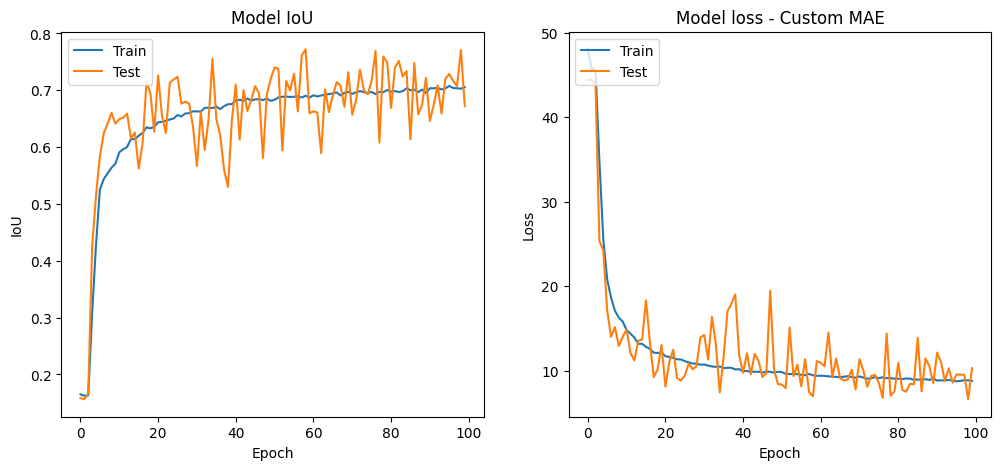

In [10]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['tf_iou'])
    plt.plot(history.history['val_tf_iou'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - Custom MAE')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

plot_training_history(history)


In [11]:
from tensorflow.keras.models import load_model

# Define the custom objects for loading the model
custom_objects = {
    'CustomCircleLoss': CustomCircleLoss,   # Custom loss class
    'tf_iou': tf_iou                         # Custom IOU metric function
}

# Load the trained model with the custom objects
best_model = load_model('best_model_10M_.h5', custom_objects=custom_objects)

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(new_test_images, new_test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Calculate Mean Absolute Error (MAE) for each component (x, y, and radius)
predicted_labels = best_model.predict(new_test_images)
mae_x = mean_absolute_error(new_test_labels[:, 0], predicted_labels[:, 0])
mae_y = mean_absolute_error(new_test_labels[:, 1], predicted_labels[:, 1])
mae_radius = mean_absolute_error(new_test_labels[:, 2], predicted_labels[:, 2])

print(f"Mean Absolute Error for X: {mae_x}")
print(f"Mean Absolute Error for Y: {mae_y}")
print(f"Mean Absolute Error for Radius: {mae_radius}")

32/32 [==============================] - 1s 12ms/step - loss: 8.2116 - tf_iou: 0.7721
Test Loss: 8.211634635925293, Test Accuracy: 0.7721384167671204
Mean Absolute Error for X: 3.585796532869339
Mean Absolute Error for Y: 3.8514699878692626
Mean Absolute Error for Radius: 3.2960214071273803


In [12]:
import tensorflow as tf
import numpy as np

def tf_iou_each(y_true, y_pred):
    """
    Calculate Intersection over Union (IoU) for each pair of true and predicted values.

    Parameters:
    - y_true (tf.Tensor): True values of the circle parameters.
    - y_pred (tf.Tensor): Predicted values of the circle parameters.

    Returns:
    tf.Tensor: Tensor of IoU values for each pair.
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Extract radii and centers
    r_true, r_pred = y_true[:, 2], y_pred[:, 2]
    centers_true, centers_pred = y_true[:, :2], y_pred[:, :2]

    # Calculate the Euclidean distance between the centers
    center_distance = tf.norm(centers_true - centers_pred, axis=1)

    def calculate_intersection():
        r1_sq, r2_sq = tf.square(r_true), tf.square(r_pred)
        d = center_distance
        d1 = (r1_sq - r2_sq + tf.square(d)) / (2 * d)
        d2 = d - d1

        # Clipping to ensure the arguments of acos and sqrt are within their valid ranges
        term1 = tf.clip_by_value(d1 / r_true, -1.0, 1.0)
        term2 = tf.clip_by_value(d2 / r_pred, -1.0, 1.0)
        term3 = tf.clip_by_value(r1_sq - tf.square(d1), 0.0, np.inf)
        term4 = tf.clip_by_value(r2_sq - tf.square(d2), 0.0, np.inf)

        # Calculate intersection area
        area1 = r1_sq * tf.math.acos(term1) - d1 * tf.sqrt(term3)
        area2 = r2_sq * tf.math.acos(term2) - d2 * tf.sqrt(term4)

        return area1 + area2

    def calculate_union():
        # Calculate the union area
        return np.pi * (tf.square(r_true) + tf.square(r_pred)) - calculate_intersection()

    def calculate_iou():
        # Handle different cases
        no_overlap = center_distance > (r_true + r_pred)
        complete_overlap = center_distance <= tf.abs(r_true - r_pred)
        iou = tf.where(
            no_overlap,
            tf.zeros_like(center_distance),
            tf.where(
                complete_overlap,
                tf.ones_like(center_distance),
                calculate_intersection() / calculate_union()
            )
        )
        return iou

    # Calculate IoU for each pair and take the mean
    return calculate_iou()

def evaluate_iou_thresholds(model, test_images, test_labels, thresholds=[0.5, 0.75, 0.9, 0.95]):
    # Predict the circles using the model
    predictions = model.predict(test_images)

    # Calculate IoU for each prediction
    ious = tf_iou_each(test_labels, predictions).numpy()  # Convert to numpy array for easier processing

    # Initialize dictionary to store results
    threshold_results = {}

    # Calculate the percentage of predictions that meet each threshold
    for threshold in thresholds:
        threshold_results[f"iou_{threshold}"] = np.mean(ious >= threshold) * 100

    return threshold_results

# Evaluate the model
iou_threshold_results = evaluate_iou_thresholds(best_model, new_test_images, new_test_labels)

# Print the results
for threshold, percentage in iou_threshold_results.items():
    print(f"Percentage of Test Examples with {threshold}: {percentage:.2f}%")


Percentage of Test Examples with iou_0.5: 87.90%
Percentage of Test Examples with iou_0.75: 63.00%
Percentage of Test Examples with iou_0.9: 33.30%
Percentage of Test Examples with iou_0.95: 27.20%


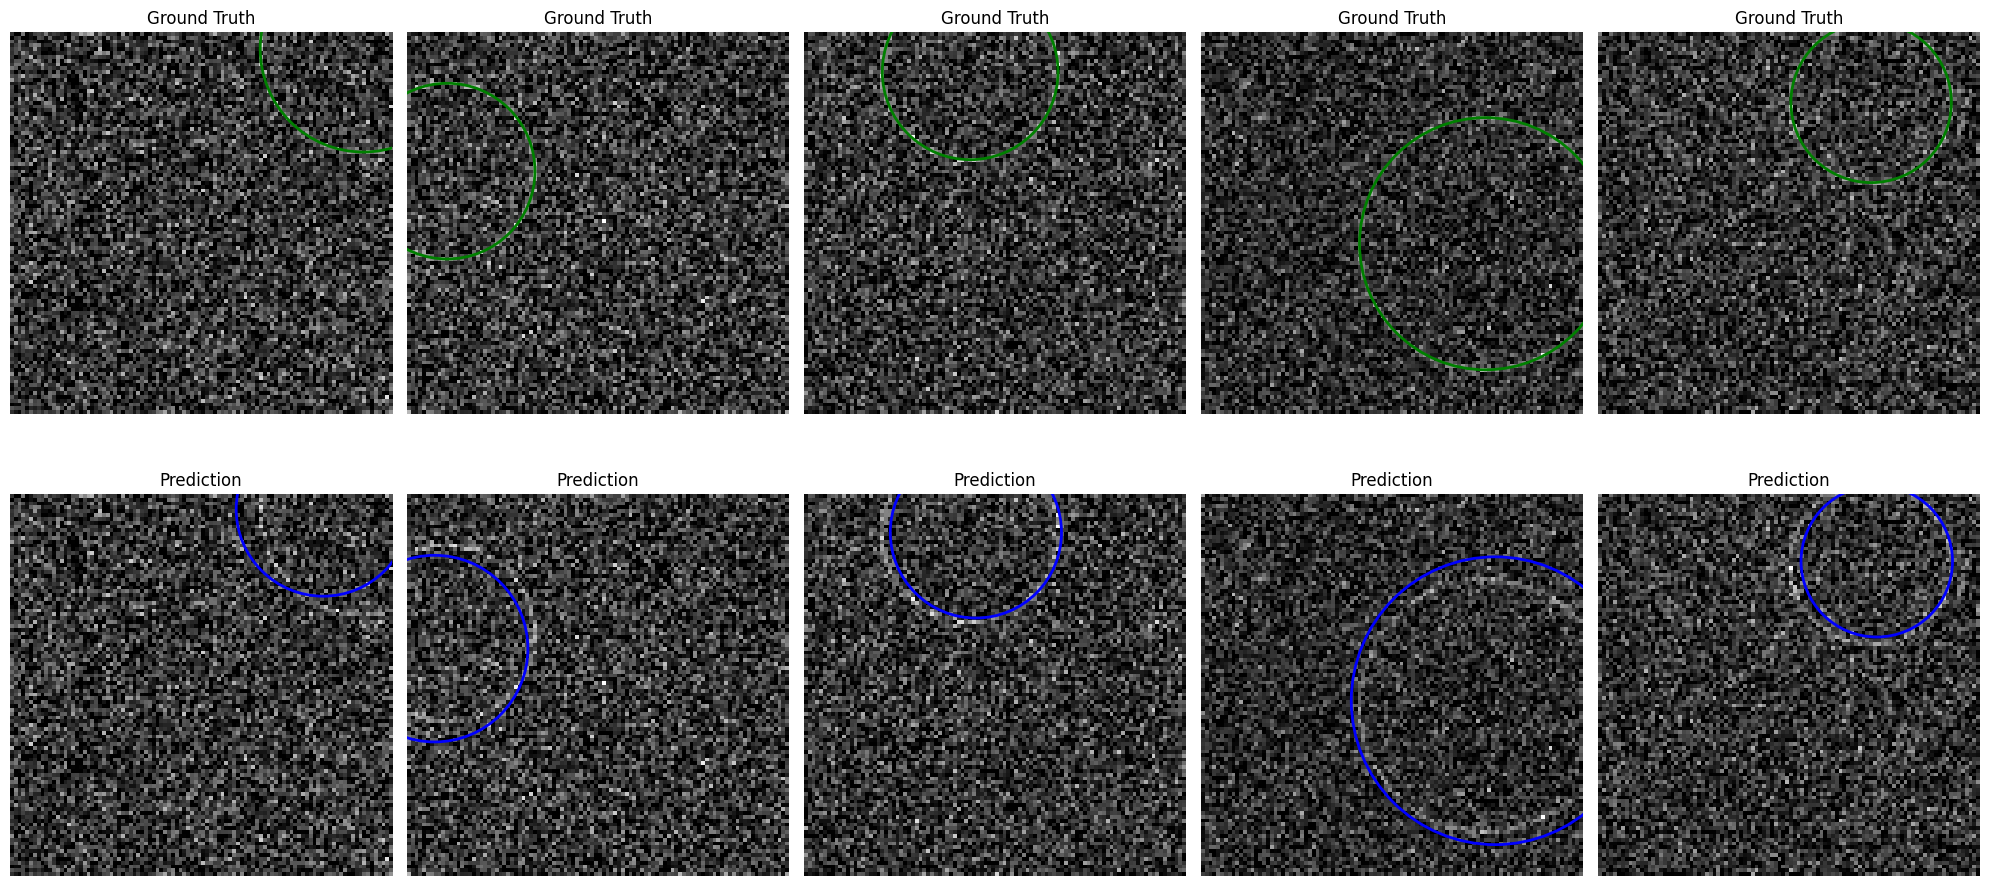

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions_horizontal(images, true_labels, predicted_labels, num_samples=5):
    
    fig, axs = plt.subplots(2, num_samples, figsize=(20, 10)) 

    for i in range(num_samples):
        j = i + 3  # Offset for selecting samples
        img = images[j].squeeze()  # Remove the channel dimension
        true_row, true_col, true_radius = true_labels[j]
        pred_row, pred_col, pred_radius = predicted_labels[j]

        # Ground Truth
        axs[0, i].imshow(img, cmap='gray')
        true_circle = patches.Circle((true_col, true_row), true_radius, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, i].add_patch(true_circle)
        axs[0, i].set_title("Ground Truth")
        axs[0, i].axis('off')

        # Prediction
        axs[1, i].imshow(img, cmap='gray')
        pred_circle = patches.Circle((pred_col, pred_row), pred_radius, linewidth=2, edgecolor='b', facecolor='none')
        axs[1, i].add_patch(pred_circle)
        axs[1, i].set_title("Prediction")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate predictions from your model
predicted_labels = best_model.predict(new_test_images)

# Visualize the predictions with ground truth in horizontal layout
visualize_predictions_horizontal(new_test_images, new_test_labels, predicted_labels, num_samples=5)


# More Robust and Deeper Model

In [14]:
from tensorflow.keras import models, layers

def create_enhanced_model(input_shape):
    """
    Creates and compiles an enhanced convolutional neural network (CNN) model.

    This function constructs a CNN model using Keras' Sequential API. The model is designed for 
    tasks involving the prediction of x, y coordinates and radius. It consists of several 
    convolutional layers followed by max pooling and dropout layers to reduce overfitting. 
    The final part of the network comprises dense layers leading to an output layer with 
    three neurons, corresponding to the x, y coordinates and radius.

    Parameters:
    - input_shape (tuple): The shape of the input data (height, width, channels).

    Returns:
    - model: A compiled TensorFlow Keras model ready for training.
    """
    model = models.Sequential([
        # Convolutional layers with 64 filters, followed by MaxPooling and Dropout
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Increased number of filters in subsequent layers for more complex feature extraction
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.15),

        # Flattening the output for the dense layer and final prediction
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(3)  # Output layer with 3 neurons for x, y coordinates and radius
    ])

    # Compile the model with Adam optimizer and custom loss and metrics
    model.compile(optimizer='adam', loss=custom_loss, metrics=[tf_iou])
    return model

# Create and display the summary of the enhanced model
model = create_enhanced_model((100, 100, 1))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 100, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 50, 50, 512)       590336    
                                                      

In [15]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Split the test set into validation and test sets
val_images, new_test_images, val_labels, new_test_labels = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42
)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    'best_model_82M.h5',                # Path where to save the model
    save_best_only=True,            # Save only the best model
    monitor='val_loss',             # Metric to monitor
    mode='min',                     # The smaller the monitored value, the better
    verbose=1                       # Verbosity mode
)

# Proceed with training
history = model.fit(
    train_images,
    train_labels,
    batch_size=32,
    epochs=100,
    validation_data=(val_images, val_labels),
    callbacks=[scale_factors_callback, checkpoint_callback]  # Include checkpoint callback
)

Epoch 1/100
249/250 [============================>.] - ETA: 0s - loss: 58.2246 - tf_iou: 0.1655
Epoch 1: val_loss improved from inf to 55.40282, saving model to best_model_82M.h5
250/250 [==============================] - 9s 35ms/step - loss: 58.2214 - tf_iou: 0.1655 - val_loss: 55.4028 - val_tf_iou: 0.1592
Epoch 2/100
250/250 [==============================] - ETA: 0s - loss: 56.3187 - tf_iou: 0.1636
Epoch 2: val_loss improved from 55.40282 to 55.35453, saving model to best_model_82M.h5
250/250 [==============================] - 9s 34ms/step - loss: 56.3187 - tf_iou: 0.1636 - val_loss: 55.3545 - val_tf_iou: 0.1551
Epoch 3/100
249/250 [============================>.] - ETA: 0s - loss: 51.5535 - tf_iou: 0.2149
Epoch 3: val_loss improved from 55.35453 to 33.48593, saving model to best_model_82M.h5
250/250 [==============================] - 9s 34ms/step - loss: 51.4715 - tf_iou: 0.2158 - val_loss: 33.4859 - val_tf_iou: 0.3884
Epoch 4/100
249/250 [============================>.] - ETA: 0s 

## Model Evaluation

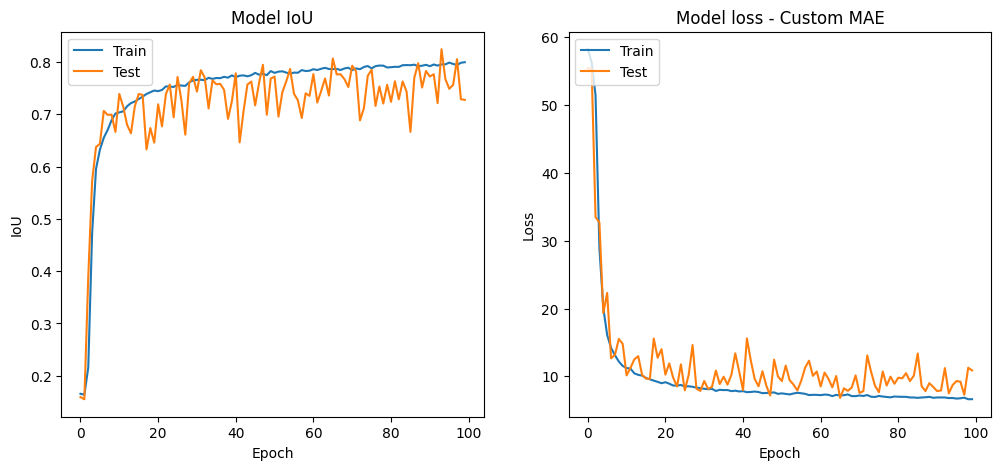

In [16]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['tf_iou'])
    plt.plot(history.history['val_tf_iou'])
    plt.title('Model IoU')
    plt.ylabel('IoU')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - Custom MAE')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

plot_training_history(history)


In [17]:
from tensorflow.keras.models import load_model


# Define the custom objects
custom_objects = {
    'CustomCircleLoss': CustomCircleLoss,
    'tf_iou': tf_iou  # Add tf_iou to the custom objects
}

# Load the model with the custom objects
best_model = load_model('best_model_82M.h5', custom_objects=custom_objects)

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(new_test_images, new_test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# For more detailed metrics like Mean Absolute Error
from sklearn.metrics import mean_absolute_error

# Predict the labels for test dataset
predicted_labels = best_model.predict(new_test_images)

# Calculate MAE for each of the label components (x, y, and radius)
mae_x = mean_absolute_error(new_test_labels[:, 0], predicted_labels[:, 0])
mae_y = mean_absolute_error(new_test_labels[:, 1], predicted_labels[:, 1])
mae_radius = mean_absolute_error(new_test_labels[:, 2], predicted_labels[:, 2])

print(f"Mean Absolute Error for X: {mae_x}")
print(f"Mean Absolute Error for Y: {mae_y}")
print(f"Mean Absolute Error for Radius: {mae_radius}")



32/32 [==============================] - 0s 9ms/step - loss: 6.7374 - tf_iou: 0.8012
Test Loss: 6.737359523773193, Test Accuracy: 0.8011640310287476
Mean Absolute Error for X: 2.9991371643543245
Mean Absolute Error for Y: 3.1147826981544493
Mean Absolute Error for Radius: 3.005524559020996


In [18]:
import tensorflow as tf
import numpy as np

def tf_iou_each(y_true, y_pred):
    # Ensure the tensor is in float32 format
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Extract radii and centers
    r_true, r_pred = y_true[:, 2], y_pred[:, 2]
    centers_true, centers_pred = y_true[:, :2], y_pred[:, :2]

    # Calculate the Euclidean distance between the centers
    center_distance = tf.norm(centers_true - centers_pred, axis=1)

    def calculate_intersection():
        r1_sq, r2_sq = tf.square(r_true), tf.square(r_pred)
        d = center_distance
        d1 = (r1_sq - r2_sq + tf.square(d)) / (2 * d)
        d2 = d - d1

        # Clipping to ensure the arguments of acos and sqrt are within their valid ranges
        term1 = tf.clip_by_value(d1 / r_true, -1.0, 1.0)
        term2 = tf.clip_by_value(d2 / r_pred, -1.0, 1.0)
        term3 = tf.clip_by_value(r1_sq - tf.square(d1), 0.0, np.inf)
        term4 = tf.clip_by_value(r2_sq - tf.square(d2), 0.0, np.inf)

        # Calculate intersection area
        area1 = r1_sq * tf.math.acos(term1) - d1 * tf.sqrt(term3)
        area2 = r2_sq * tf.math.acos(term2) - d2 * tf.sqrt(term4)

        return area1 + area2

    def calculate_union():
        # Calculate the union area
        return np.pi * (tf.square(r_true) + tf.square(r_pred)) - calculate_intersection()

    def calculate_iou():
        # Handle different cases
        no_overlap = center_distance > (r_true + r_pred)
        complete_overlap = center_distance <= tf.abs(r_true - r_pred)
        iou = tf.where(
            no_overlap,
            tf.zeros_like(center_distance),
            tf.where(
                complete_overlap,
                tf.ones_like(center_distance),
                calculate_intersection() / calculate_union()
            )
        )
        return iou

    # Calculate IoU for each pair and take the mean
    return calculate_iou()

def evaluate_iou_thresholds(model, test_images, test_labels, thresholds=[0.5, 0.75, 0.9, 0.95]):
    # Predict the circles using the model
    predictions = model.predict(test_images)

    # Calculate IoU for each prediction
    ious = tf_iou_each(test_labels, predictions).numpy()  # Convert to numpy array for easier processing

    # Initialize dictionary to store results
    threshold_results = {}

    # Calculate the percentage of predictions that meet each threshold
    for threshold in thresholds:
        threshold_results[f"iou_{threshold}"] = np.mean(ious >= threshold) * 100

    return threshold_results

# Evaluate the model
iou_threshold_results = evaluate_iou_thresholds(best_model, new_test_images, new_test_labels)

# Print the results
for threshold, percentage in iou_threshold_results.items():
    print(f"Percentage of Test Examples with {threshold}: {percentage:.2f}%")


Percentage of Test Examples with iou_0.5: 89.80%
Percentage of Test Examples with iou_0.75: 68.90%
Percentage of Test Examples with iou_0.9: 39.90%
Percentage of Test Examples with iou_0.95: 31.50%


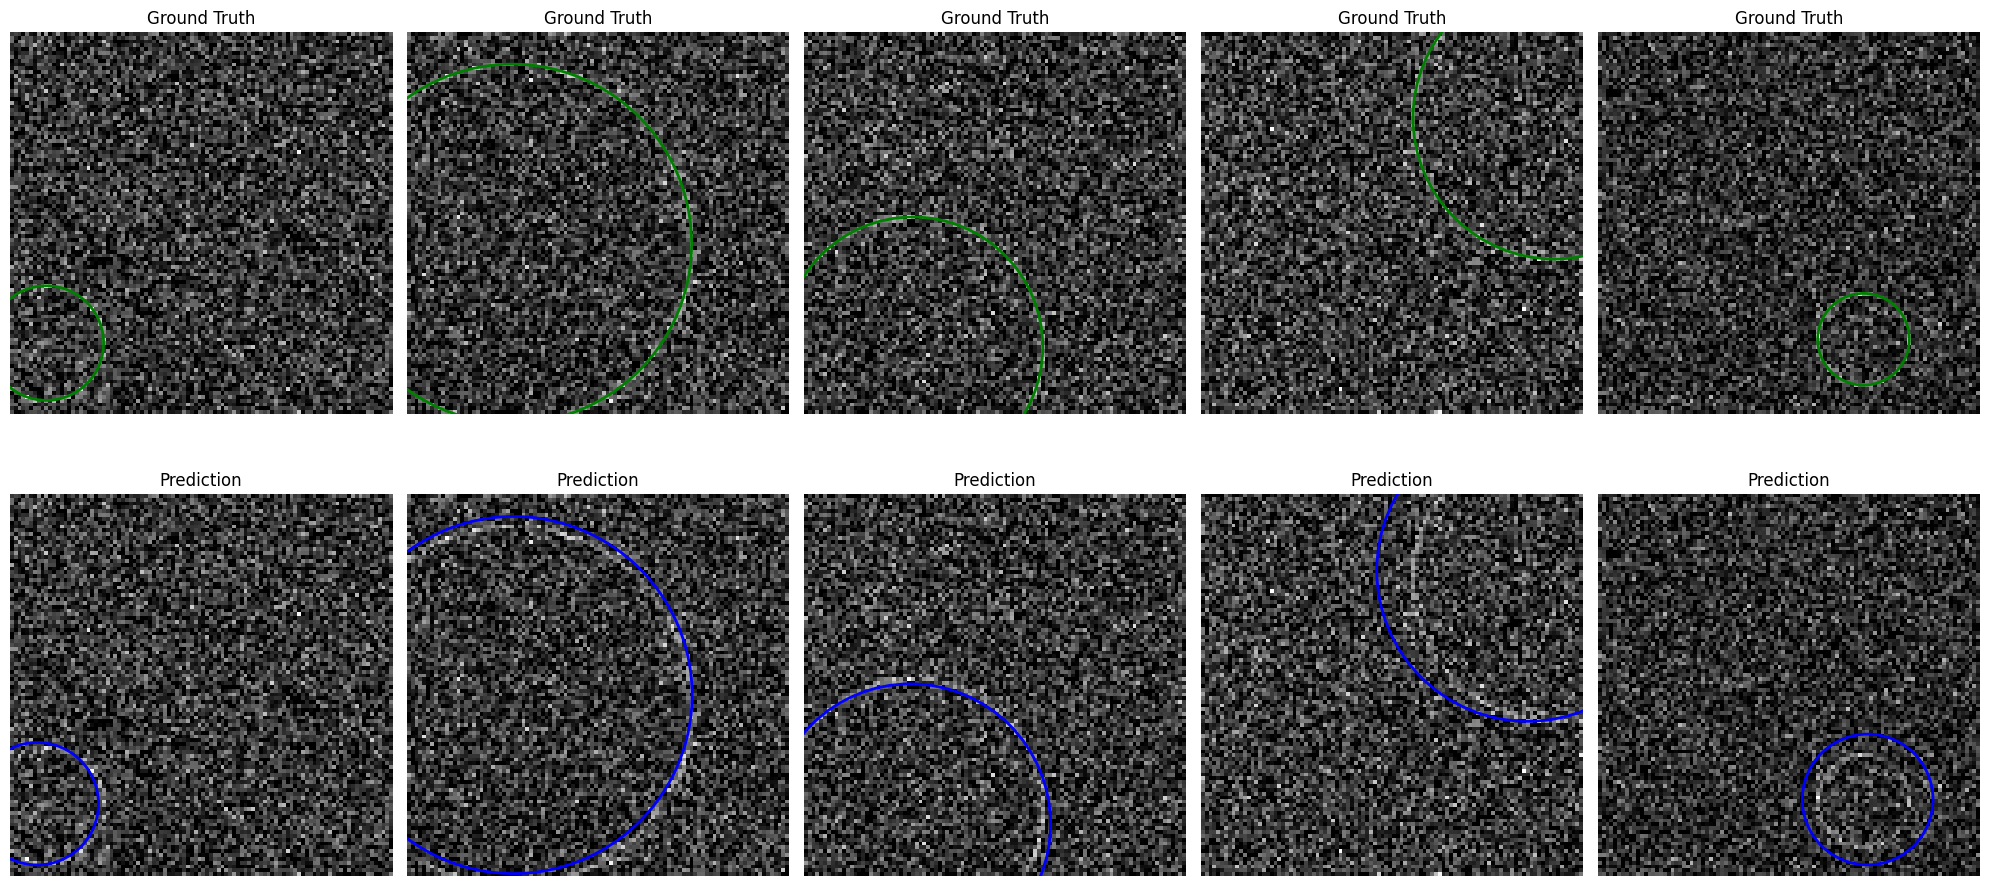

In [79]:
def visualize_predictions_horizontal(images, true_labels, predicted_labels, num_samples=5):
    # 2 rows for ground truth and prediction, num_samples columns
    fig, axs = plt.subplots(2, num_samples, figsize=(20, 10)) 

    for i in range(num_samples):
        j = i + 3  # Offset for selecting samples
        img = images[j].squeeze()  # Remove the channel dimension
        true_row, true_col, true_radius = true_labels[j]
        pred_row, pred_col, pred_radius = predicted_labels[j]

        # Ground Truth
        axs[0, i].imshow(img, cmap='gray')
        true_circle = patches.Circle((true_col, true_row), true_radius, linewidth=2, edgecolor='g', facecolor='none')
        axs[0, i].add_patch(true_circle)
        axs[0, i].set_title("Ground Truth")
        axs[0, i].axis('off')

        # Prediction
        axs[1, i].imshow(img, cmap='gray')
        pred_circle = patches.Circle((pred_col, pred_row), pred_radius, linewidth=2, edgecolor='b', facecolor='none')
        axs[1, i].add_patch(pred_circle)
        axs[1, i].set_title("Prediction")
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate predictions from your model
predicted_labels = best_model.predict(new_test_images)

# Visualize the predictions with ground truth in horizontal layout
visualize_predictions_horizontal(new_test_images, new_test_labels, predicted_labels, num_samples=5)


---- END ------